In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target

x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [3]:
from sklearn.linear_model import SGDClassifier

In [4]:
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.8333333333333334

In [5]:
sgd = SGDClassifier(loss='hinge', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.9385964912280702

### 검증 세트 분할(train_test_split 한번 더 사용)

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [7]:
print(len(x_train), len(y_train))

364 364


In [8]:
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_val, y_val)


0.6923076923076923

### 특성의 스케일(변동의 크기)은 알고리즘의 영향을 줌

['mean perimeter' 'mean area']


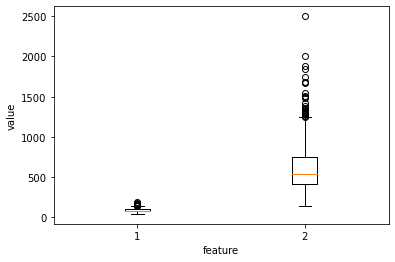

In [9]:
print(cancer.feature_names[[2, 3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')

plt.show()

In [10]:
# 가중치를 기록하는 변수와 학습률 파라미터 추가

class SingleLayer:
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
        
    def forpass(self, x):
        z = np.sum(x * self.w) + self.b # 직선 방정식을 계산
        return z 
    
    def backprop(self, x, err):
        w_grad = x * err # 가중치에 대한 그래디언트 계산
        b_grad = 1 * err  # 절편에 대한 그래디언트 계산
        return w_grad, b_grad
    
    def activation(self, z):
        z = np.clip(z, -100, None) # 안전한 np.exp() 계산을 위해 
        a = 1 / (1 + np.exp(-z)) # 시그모이드 계산 
        
        return a 
    def fit(self, x, y, epochs=100):
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy()) # 가중치 기록
        np.random.seed(42)

        for i in range(epochs):
            loss = 0
            # 인덱스를 섞는다 (확률적 경사 하강법): 1개의 샘플을 중복되지 않도록 무작위로 선택
            indexes = np.random.permutation(np.arange(len(x)))
            
            for i in indexes:
                z = self.forpass(x[i])
                a = self.activation(z)
                
                err = -(y[i] - a)
                
                w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
                
                # 그래디언트에서 패널티 항의 미분 값을 더한다. 
                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
                self.w -= self.lr * w_grad
                self.b -= self.lr * b_grad
                
                # 가중치 기록
                self.w_history.append(self.w.copy())
                
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적 
                a = np.clip(a, 1e-10, 1-1e-10)
                
                loss += -(y[i]*np.log(a) + (1-y[i])*np.log(1-a))
                
            # 에포크마다 평균 손실을 저장 
            self.losses.append(loss/len(y))
            
            # 검증 세트에 대한 손실 계산
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]
        return np.array(z) > 0 # 스텝 함수 적용
        
    def score(self, x, y):
        return np.mean(self.predict(x)==y)

In [11]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

0.9120879120879121

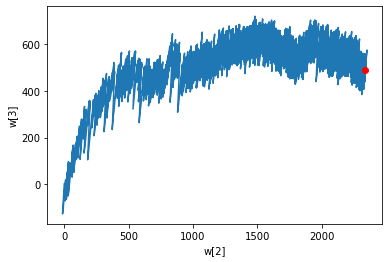

In [12]:
w2 = [] # mean perimeter

w3 = [] # mean area

for w in layer1.w_history:
    w2.append(w[2])
    
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')

plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()
# 스케일을 조정하지 않으면, 가중치 변화가 불안정하고, 최종 가중치를 찾는 과정이 비효율적
    


In [13]:
# 표준화 진행
train_mean = np.mean(x_train, axis=0)

train_std = np.std(x_train, axis=0)

x_train_scaled = (x_train - train_mean) / train_std

In [14]:
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)

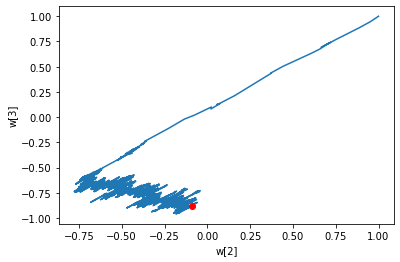

In [15]:
w2 = [] # mean perimeter

w3 = [] # mean area

for w in layer2.w_history:
    w2.append(w[2])
    
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')

plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()
# 스케일을 조정하지 않으면, 가중치 변화가 불안정하고, 최종 가중치를 찾는 과정이 비효율적
    


    - 최종 가중치로 안정적이고 빠르게 수렴

In [16]:
# 검증 세트의 평균, 표준 편차로 검증 세트 표준화 x 
# 훈련 세트와 검증 세트의 평균과 표준편차가 다르기 떄문에 올바른 성능 평가가 아님

In [17]:
layer2.score(x_val, y_val)

0.37362637362637363

In [18]:
# 표준화 진행
val_mean = np.mean(x_val, axis=0)

val_std = np.std(x_val, axis=0)

x_val_scaled = (x_val - val_mean) / val_std

In [19]:
layer2.score(x_val_scaled, y_val)

0.967032967032967

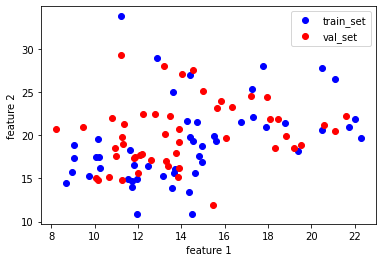

In [20]:
plt.plot(x_train[:50, 0], x_train[:50, 1], 'bo')
plt.plot(x_val[:50, 0], x_val[:50, 1], 'ro')

plt.xlabel('feature 1')
plt.ylabel('feature 2')

plt.legend(['train_set', 'val_set'])
plt.show()

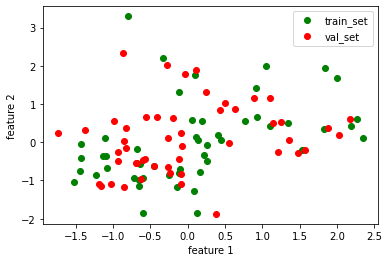

In [21]:
# 검증 세트의 평균, 표준 편차로 겸증세트를 표준화 할 경우 
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'go')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')

plt.xlabel('feature 1')
plt.ylabel('feature 2')

plt.legend(['train_set', 'val_set'])
plt.show()

- 각 데이터 간의 거리가 달라짐 -> 잘못된 성능 평가

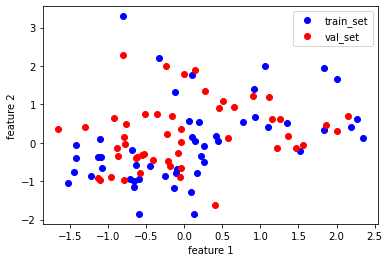

In [22]:
x_val_scaled = (x_val - train_mean) / train_std
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')

plt.xlabel('feature 1')
plt.ylabel('feature 2')

plt.legend(['train_set', 'val_set'])
plt.show()


훈련 세트의 평균, 표준 편차로 검증 세트를 표준화 할 경우 -> 올바른 평가

In [ ]:
# 가중치를 기록하는 변수와 학습률 파라미터 추가

class SingleLayer:
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
        
    def forpass(self, x):
        z = np.sum(x * self.w) + self.b # 직선 방정식을 계산
        return z 
    
    def backprop(self, x, err):
        w_grad = x * err # 가중치에 대한 그래디언트 계산
        b_grad = 1 * err  # 절편에 대한 그래디언트 계산
        return w_grad, b_grad
    
    def activation(self, z):
        z = np.clip(z, -100, None) # 안전한 np.exp() 계산을 위해 
        a = 1 / (1 + np.exp(-z)) # 시그모이드 계산 
        
        return a 
    def fit(self, x, y, epochs=100):
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy()) # 가중치 기록
        np.random.seed(42)

        for i in range(epochs):
            loss = 0
            # 인덱스를 섞는다 (확률적 경사 하강법): 1개의 샘플을 중복되지 않도록 무작위로 선택
            indexes = np.random.permutation(np.arange(len(x)))
            
            for i in indexes:
                z = self.forpass(x[i])
                a = self.activation(z)
                
                err = -(y[i] - a)
                
                w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
                
                # 그래디언트에서 패널티 항의 미분 값을 더한다. 
                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
                self.w -= self.lr * w_grad
                self.b -= self.lr * b_grad
                
                # 가중치 기록
                self.w_history.append(self.w.copy())
                
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적 
                a = np.clip(a, 1e-10, 1-1e-10)
                
                loss += -(y[i]*np.log(a) + (1-y[i])*np.log(1-a))
                
            # 에포크마다 평균 손실을 저장 
            self.losses.append(loss/len(y))
            
            # 검증 세트에 대한 손실 계산
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]
        return np.array(z) > 0 # 스텝 함수 적용
        
    def score(self, x, y):
        return np.mean(self.predict(x)==y)
    

    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        # 검증 세트 손실 기록 로지스틱 손실
        if x_val is None:
            return 
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])
            a = self.activation(z)
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())
            